# Synthetic data with Kernel Density Estimation

## Introduction

In this notebook synthetic data is generated using Kernel Density Estimation.

The example uses a publically accessible data set of personal information, collected from a restaurant booking system.

Four features are accepted from the table of personal information:

* smoker
* birth_year
* drinker
* activity (occupation status)

In addition to these four features, two additional features are created entirely synthetically. The approval field is a binary flag indicating whether an applicant has been approved or rejected. Gender and Approval are with the following priors:

* gender $P(female) = 0.35, P(male) = 0.65$
* approval $P(approval | female) = 0.38, P(approval | male) = 0.62$

Approval has been set with a conditional prior such that when modelling the synthetic data generated, it will be possible to evaluate whether these priors persist in the faked data.

### Generating synthetic data using KDE

Kernel Density is estimated using the KernelDensity class within Python's Sci-kit Learn package. 

For each of the features *smoker, birth_year, drinker, activity, gender and approval*, the distribution is learned. The learned distribution for each feature is then sampled to produce *n* samples of new data.

## Example code

Load the package dependencies and source data. Prune to select the four target features.

In [10]:
import numpy as np
from sklearn.neighbors.kde import KernelDensity
import pymc3 as pm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv("./data/rcdata/userprofile.csv")
df = df[["smoker", "birth_year", "drink_level", "activity"]]
df.head()

smoker  birth_year     drink_level      activity
0  false        1989      abstemious       student
1  false        1990      abstemious       student
2  false        1989  social drinker       student
3  false        1940      abstemious  professional
4  false        1992      abstemious       student

Convert the string attributes to categorical features and numbers to integers.

In [11]:
categorical_fields = [
    "smoker",
    "drink_level",
    "activity"
]

cats = {
    
}

for field in categorical_fields:
    df[field] = df[field].astype('category')
    cats[field] = dict( zip( df[field].cat.codes, df[field] ) )
    df[[field]] = df[[field]].apply(lambda x: x.cat.codes)

numeric_fields = [
    "birth_year"
]

for field in numeric_fields:
    df[field] = df[field].astype('int32')

df.head()

smoker  birth_year  drink_level  activity
0       1        1989            0         2
1       1        1990            0         2
2       1        1989            2         2
3       1        1940            0         1
4       1        1992            0         2

Create distribution from priors for missing columns. Categorical features are selected by weighted choice and fit back to source data.

In [12]:
from numpy.random import choice

# create gender variable
gender = choice([0,1], len(df), p=[0.35, 0.65])
df["gender"] = gender

# create approval variable
conditional_priors = { 0: [0.62, 0.38], 1: [0.38,0.62] }
approval_columns = []
for gender in [0,1]:
    mask = (df["gender"] == gender)
    g_df = df.loc[mask]
    approval = choice([0,1], len(g_df), p=conditional_priors[gender])
    g_df["approved"] = approval
    approval_columns.append(g_df)

# merge synthetic fields back in to source data
df = pd.concat(approval_columns)
for field in ["gender", "approved"]:
    df[field] = df[field].astype('category')
    df[[field]] = df[[field]].apply(lambda x: x.cat.codes)
df.head(10)

smoker  birth_year  drink_level  activity  gender  approved
0        1        1989            0         2       0         0
3        1        1940            0         1       0         0
5        2        1989            2         2       0         0
7        1        1989            2         2       0         1
10       1        1989            0         2       0         1
11       1        1988            1         2       0         1
12       1        1982            0         1       0         0
14       2        1989            2         2       0         0
15       1        1991            1         2       0         0
20       1        1984            2         2       0         0

For each attribute, fit KDE models at 10, 40 and 100 bandwidth. The higher the bandwidth, the more noise is tolerated.

In [13]:
kernels = { f: {} for f in df.columns}

for f in df.columns:
    X = df[f].values[:, np.newaxis]
    kernels[f] = KernelDensity(kernel='gaussian', bandwidth=0.3)
    kernels[f].fit(X)    

Generate one million synthetic attributes from the KDE model and plot against the real data. Do they obey the same distributions?

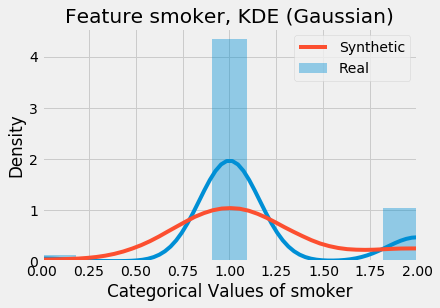

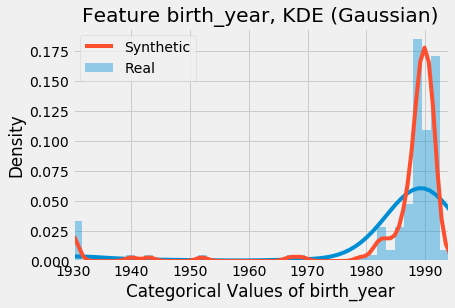

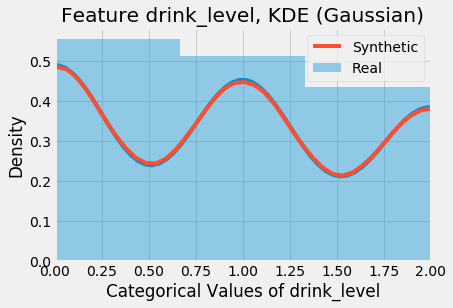

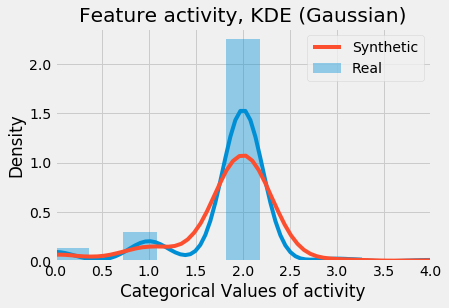

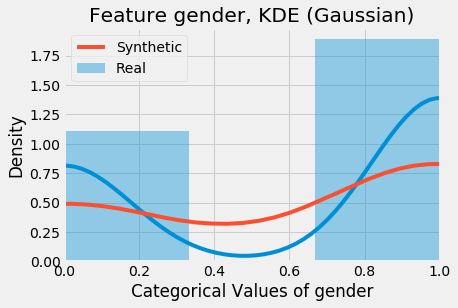

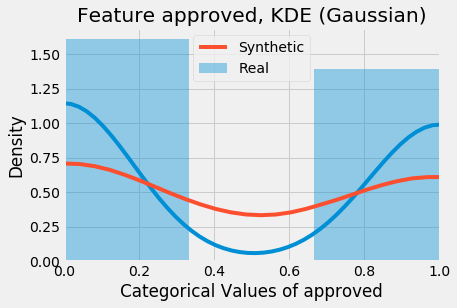

In [16]:
synthetic = { f: [] for f in df.columns }

for f in df.columns:
    sd = kernels[f].sample(1000000, random_state=0)
    synthetic[f] = sd
    fig, ax = plt.subplots(1, figsize=(6, 4))
    sns.distplot(df[[f]], label="Real");
    sns.distplot(sd, hist=False, label="Synthetic");
    ax.legend()
    ax.set_xlim(df[f].min(), df[f].max())
    ax.set_title("Feature {}, KDE (Gaussian)".format(f))
    ax.set_xlabel("Categorical values of feature '{}'".format(f))
    ax.set_ylabel("Density")
    plt.savefig("./images/dist_{}".format(f))
    plt.show()

Convert the synthetic samples to a dataframe and scale the KDE estimates to the closest real categoricals.

In [6]:
from sklearn.preprocessing import MinMaxScaler
def find_closest_class(column_name, i):
    value = (np.abs(df[column_name].unique()-i)).argmin()
    return round(value,0)

synth_for_df = synthetic.copy()
for f in df.columns:
    values = [int(round(v[0],0)) for v in synth_for_df[f]]
    synth_for_df[f] = values
synth_df = pd.DataFrame.from_dict(synth_for_df)

for col in ["gender", "approved"]:
    scaler = MinMaxScaler()
    scaler = scaler.fit(df[[col]])
    synth_df[[col]] = scaler.transform(synth_df[[col]])

for f in synth_df.columns:
    if f in categorical_fields or f in ["gender", "approved"]:
        synth_df[f] = synth_df[f].apply(lambda x: find_closest_class(f, x))

determine if each synthetic row existed verbatim in the source data

In [7]:
duplication_df = pd.merge(synth_df, df, on=[col for col in df.columns], how='left', indicator='Exist')
duplication_df['Exist'] = np.where(duplication_df.Exist == 'both', True, False)

Save the unique synthetic data to a CSV file

In [8]:
mask = (duplication_df['Exist'] == False)
unique_rows = duplication_df.loc[mask]
print("Created {} unique rows".format(len(unique_rows)))
unique_rows.to_csv('./kde_synthetic_data.csv')
unique_rows.head(10)

Created 958248 unique rows


smoker  birth_year  drink_level  activity  gender  approved  Exist
0       0        1990            0         0       1         0  False
1       0        1988            2         0       1         0  False
2       0        1989            0         0       1         0  False
3       0        1990            0         0       1         0  False
4       0        1991            2         0       0         1  False
5       0        1979            2         1       1         1  False
6       0        1991            0         0       0         0  False
7       0        1982            1         1       1         0  False
8       0        1986            2         0       1         0  False
9       0        1991            1         0       0         1  False

Evaluate the properties of the synthetic data. Plot the distribution and conditional distributions in the real data and the synthetic data.

 
Probability distributions for attribute birth_year
---------------------


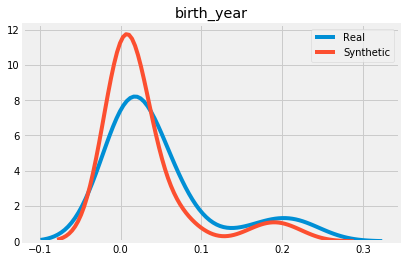

---------------------


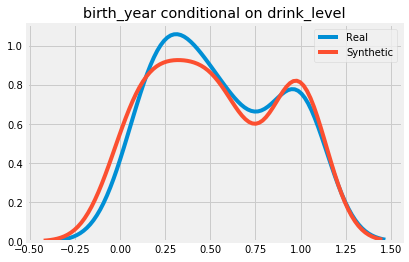

---------------------


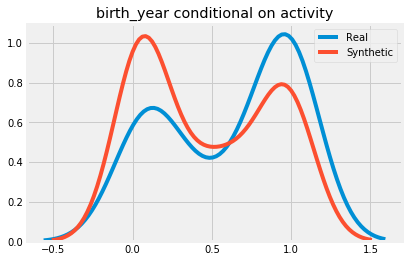

---------------------


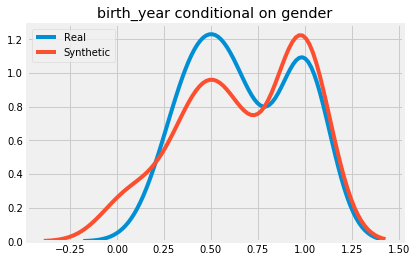

---------------------


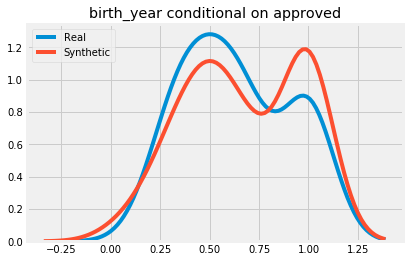

---------------------
 
Probability distributions for attribute drink_level
---------------------


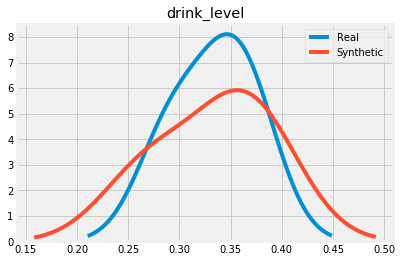

---------------------


---------------------


---------------------


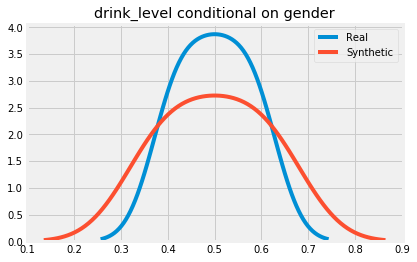

---------------------


---------------------
 
Probability distributions for attribute activity
---------------------


---------------------


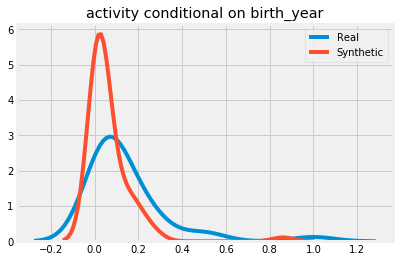

---------------------


---------------------


---------------------


---------------------
 
Probability distributions for attribute gender
---------------------


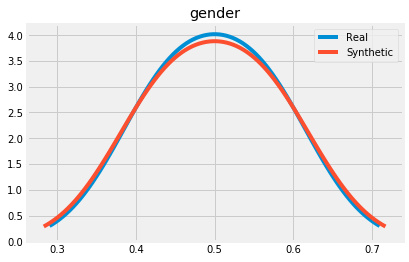

---------------------


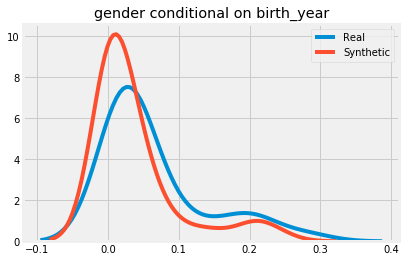

---------------------


---------------------


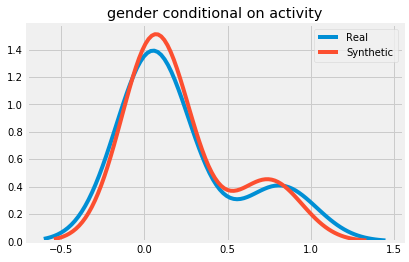

---------------------


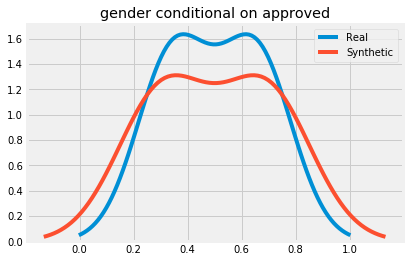

---------------------
 
Probability distributions for attribute approved
---------------------


---------------------


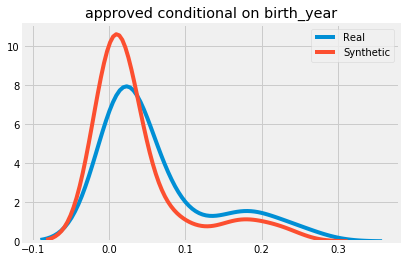

---------------------


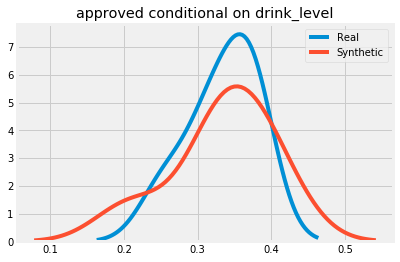

---------------------


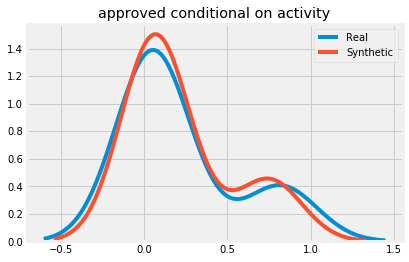

---------------------


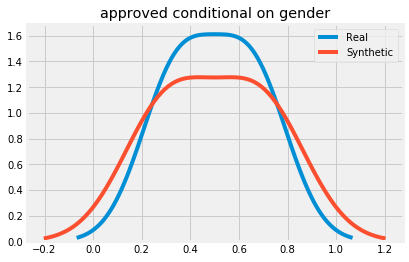

---------------------


In [9]:
for f in synth_df.columns[1:]:
    print (" ")
    print ("Probability distributions for attribute {}".format(f))
    print ("---------------------")
    obs_prob = df.groupby(f).size().div(len(df))
    synth_prob = unique_rows.groupby(f).size().div(len(unique_rows))
    plt.title(f)
    sns.distplot([obs for obs in obs_prob], label="Real", hist=False);
    sns.distplot([round(v, 2) for v in [obs for obs in synth_prob]], hist=False, label="Synthetic");
    plt.savefig("./images/{}.png".format(f))
    plt.show() 
    for obs_f in synth_df.columns[1:]:
        if obs_f == f:
            continue
        print ("---------------------")
        obs_cond = df.groupby([obs_f,f]).size().div(len(df)).div(obs_prob, axis=0, level=f)
        synth_cond = unique_rows.groupby([obs_f,f]).size().div(len(unique_rows)).div(synth_prob, axis=0, level=f)
        plt.title("{} conditional on {}".format(f, obs_f))
        sns.distplot([obs for obs in obs_cond], label="Real", hist=False);
        sns.distplot([round(v, 2) for v in [obs for obs in synth_cond]], hist=False, label="Synthetic");
        plt.savefig("./images/{}_{}.png".format(f, obs_f))
        plt.show()        
    print ("---------------------")